In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

print ('Done')

Done


In [2]:
data_dir = 'archive'
filepaths = []
labels = []

In [3]:
folds = os.listdir(data_dir)

In [4]:
os.path.join(data_dir, 'Anthracnose')

'archive/Anthracnose'

In [5]:
os.listdir('archive/Anthracnose')

['20211008_124249 (Custom).jpg',
 '20211008_124250 (Custom).jpg',
 '20211008_124252 (Custom).jpg',
 '20211008_124253 (Custom).jpg',
 '20211008_124256 (Custom).jpg',
 '20211008_124301 (Custom).jpg',
 '20211008_124302 (Custom).jpg',
 '20211008_124305 (Custom).jpg',
 '20211008_124306 (Custom).jpg',
 '20211008_124310 (Custom).jpg',
 '20211008_124312 (Custom).jpg',
 '20211008_124334 (Custom).jpg',
 '20211008_124336 (Custom).jpg',
 '20211008_124341 (Custom).jpg',
 '20211008_124345 (Custom).jpg',
 '20211008_124457 (Custom).jpg',
 '20211008_124501 (Custom).jpg',
 '20211008_124522 (Custom).jpg',
 '20211008_124524 (Custom).jpg',
 '20211008_124624 (Custom).jpg',
 '20211008_124632 (Custom).jpg',
 '20211008_124907 (Custom).jpg',
 '20211008_124917 (Custom).jpg',
 '20211008_124931 (Custom).jpg',
 '20211008_124933 (Custom).jpg',
 '20211008_125014 (Custom).jpg',
 '20211008_125016 (Custom).jpg',
 '20211008_125052 (Custom).jpg',
 '20211008_125056 (Custom).jpg',
 '20211008_125100 (Custom).jpg',
 '20211008

In [6]:
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

In [7]:
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)

In [8]:
data.head()

,filepaths,labels
0,archive/Anthracnose/20211008_124249 (Custom).jpg,Anthracnose
1,archive/Anthracnose/20211008_124250 (Custom).jpg,Anthracnose
2,archive/Anthracnose/20211008_124252 (Custom).jpg,Anthracnose
3,archive/Anthracnose/20211008_124253 (Custom).jpg,Anthracnose
4,archive/Anthracnose/20211008_124256 (Custom).jpg,Anthracnose


In [20]:
classes = list(data['labels'].unique())
classes

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

In [11]:
train_df

,filepaths,labels
2413,archive/Gall Midge/IMG_20211106_165644 (Custom...,Gall Midge
1658,archive/Die Back/20211129_162013 (Custom).jpg,Die Back
2610,archive/Healthy/20211231_125015 (Custom).jpg,Healthy
1105,archive/Cutting Weevil/20211011_161345 (Custom...,Cutting Weevil
1983,archive/Die Back/IMG_20211028_003200 (Custom).jpg,Die Back
...,...,...
2338,archive/Gall Midge/IMG_20211106_164207 (Custom...,Gall Midge
98,archive/Anthracnose/20211011_134634 (Custom).jpg,Anthracnose
1206,archive/Cutting Weevil/20211011_161715(0) (Cus...,Cutting Weevil
3236,archive/Powdery Mildew/IMG_20211107_122401 (Cu...,Powdery Mildew


In [12]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2560 validated image filenames belonging to 8 classes.
Found 640 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [14]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

num_classes = len(train_generator.class_indices)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Step 6: Compile the Model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/25


I0000 00:00:1746465454.635388    1101 service.cc:152] XLA service 0x7fde3c010c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746465454.635483    1101 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-05-05 17:17:34.834720: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746465456.159461    1101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/80 ━━━━━━━━━━━━━━━━━━━━ 26:01 20s/step - accuracy: 0.0938 - loss: 3.5515

I0000 00:00:1746465469.379768    1101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.1960 - loss: 2.6038

2025-05-05 17:19:09.121777: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 204 bytes spill stores, 204 bytes spill loads

2025-05-05 17:19:09.220720: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1202', 4 bytes spill stores, 4 bytes spill loads

2025-05-05 17:19:09.220941: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195_0', 464 bytes spill stores, 1372 bytes spill loads

2025-05-05 17:19:09.966864: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 5616 bytes spill stores, 5612 bytes spill loads

2025-05-05 17:19:09.980438: I e

80/80 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.1967 - loss: 2.5995 - val_accuracy: 0.6672 - val_loss: 1.2604 - learning_rate: 1.0000e-04
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 518ms/step - accuracy: 0.4598 - loss: 1.5892 - val_accuracy: 0.7828 - val_loss: 0.8138 - learning_rate: 1.0000e-04
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 478ms/step - accuracy: 0.6012 - loss: 1.1287 - val_accuracy: 0.8438 - val_loss: 0.5653 - learning_rate: 1.0000e-04
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 271ms/step - accuracy: 0.6883 - loss: 0.8954 - val_accuracy: 0.8813 - val_loss: 0.4460 - learning_rate: 1.0000e-04
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - accuracy: 0.7351 - loss: 0.7533 - val_accuracy: 0.9000 - val_loss: 0.3595 - learning_rate: 1.0000e-04
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 276ms/step - accuracy: 0.7714 - loss: 0.6646 - val_accuracy: 0.9109 - val_loss: 0.3034 - learning_rate: 1.0000e-04
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - accuracy: 0.7988

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - accuracy: 0.9665 - loss: 0.0935
Test Accuracy: 95.88%


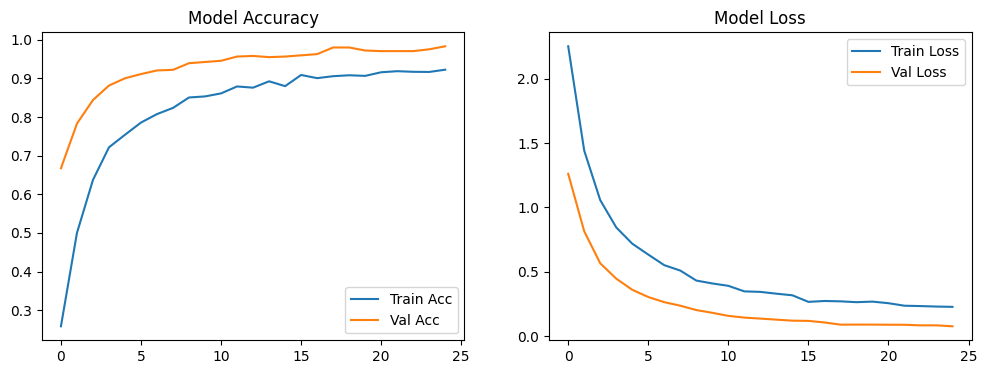

In [18]:
# Step 9: Evaluate the Model
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

# Step 10: Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [19]:
model.save("mango_leaf_model_3.h5")

Test Accuracy: 95.88%
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step


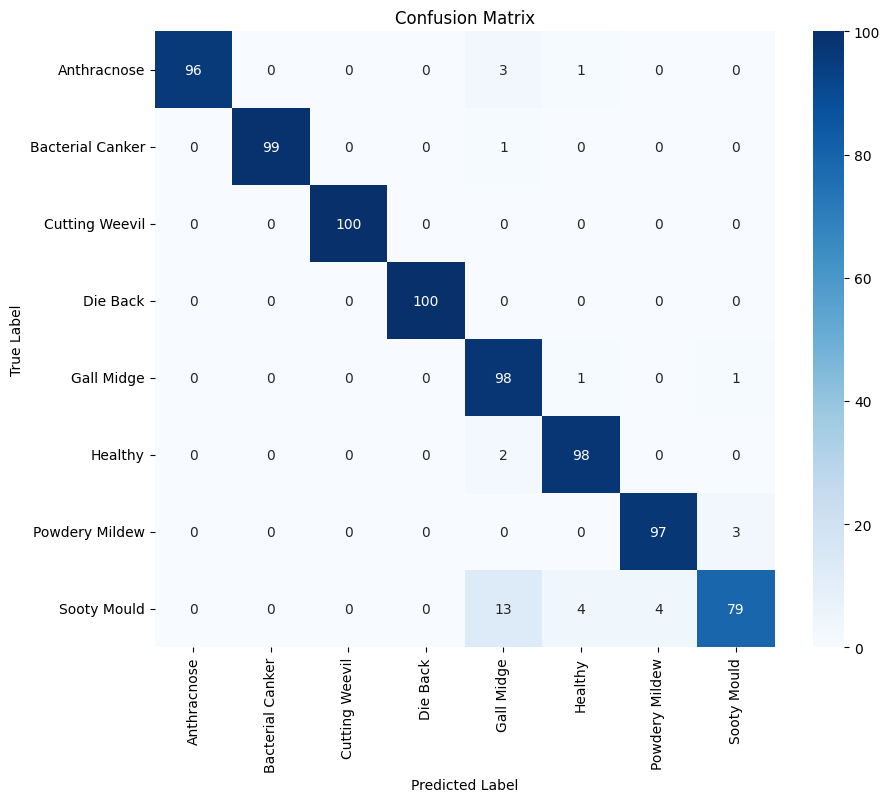

                  precision    recall  f1-score   support

     Anthracnose       1.00      0.96      0.98       100
Bacterial Canker       1.00      0.99      0.99       100
  Cutting Weevil       1.00      1.00      1.00       100
        Die Back       1.00      1.00      1.00       100
      Gall Midge       0.84      0.98      0.90       100
         Healthy       0.94      0.98      0.96       100
  Powdery Mildew       0.96      0.97      0.97       100
     Sooty Mould       0.95      0.79      0.86       100

        accuracy                           0.96       800
       macro avg       0.96      0.96      0.96       800
    weighted avg       0.96      0.96      0.96       800



In [22]:
scores = model.evaluate(x=test_generator, verbose=0)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

y_pred = np.argmax(model.predict(test_generator), axis=1)
    
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

print(classification_report(test_generator.classes, y_pred, target_names=classes))

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a single image for prediction
img_path = 'archive/Healthy/20211231_124442 (Custom).jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Model expects batch dimension

# Predict
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
class_label = list(train_generator.class_indices.keys())[predicted_class]

print("Predicted class:", class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted class: Healthy
